In [1]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw
import copy

setup geometry

In [5]:
geo = SplineGeometry()
geo.AddRectangle( (-3,-2), (3, 2), bcs = ("top", "out", "bot", "in"))
geo.AddCircle ( (0, 0), r=0.5, leftdomain=0, rightdomain=1, bc="cyl")
mesh = Mesh( geo.GenerateMesh(maxh=0.2))
mesh.Curve(3);
mesh_orig = copy.deepcopy(mesh)
#Draw(mesh)

setup FEM space

In [6]:
# viscosity
nu = 0.01
# Order of spaces
k = 2
# H1 vs VectorH1 -> vector field?!
V = H1(mesh,order=k, dirichlet="top|bot|cyl|in|out")
Q = H1(mesh,order=k-1)
FES = FESpace([V,V,Q]) # X = [V,Q] (without VectorH1)

setup bilinear form
velocityfield u and pressurefield p

In [7]:
ux,uy,p = FES.TrialFunction()
vx,vy,q = FES.TestFunction()

# stokes equation
def Equation(ux,uy,p,vx,vy,q):
    div_u = grad(ux)[0]+grad(uy)[1] # custom div
    div_v = grad(vx)[0]+grad(vy)[1]
    return (grad(ux)*grad(vx)+grad(uy)*grad(vy) + div_u*q + div_v*p) * dx


# (InnerProduct(grad(u),grad(v))+div(u)*q+div(v)*p)*dx
a = BilinearForm(FES)
a += Equation(ux,uy,p,vx,vy,q)
a.Assemble()

setup boundary conditions

In [8]:
gfu = GridFunction(FES)
uinf = 0.001
uin = CoefficientFunction((uinf))
gfu.components[0].Set(uin, definedon=mesh.Boundaries("in|top|bot|out"))

x_velocity = CoefficientFunction(gfu.components[0])
scene_state = Draw(x_velocity, mesh, "vel")

WebGuiWidget(value={'ngsolve_version': '6.2.2201', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

solve stokes

In [9]:
def solveStokes():
    res = gfu.vec.CreateVector()
    res.data = -a.mat * gfu.vec
    inv = a.mat.Inverse(FES.FreeDofs())
    gfu.vec.data += inv * res
    scene_state.Redraw()
solveStokes()

# Calculations/Setup for all the side constraints

Drag/ "dissipated energy" [should be working]

$J(\Omega ) = \frac{1}{2} \int_\Omega Du : Du dx$ 

In [177]:
def calc_drag(gfu):
    ux = gfu.components[0]
    uy = gfu.components[1]
    return 0.5*(grad(ux)*grad(ux)+grad(uy)*grad(uy))*dx

### get surface area of mesh (main issue)
$vol(\Omega) = \int_{\Omega} 1 \,dx \in \mathbb{R}$ should stay constant <br>
entire area: $A = 6*4=24$ <br>
$\alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2$

In [178]:
alpha = 1e-4
surf_t = CoefficientFunction(1)
surf_0 = Integrate(surf_t,mesh)

def calc_surf_change():
    return alpha*(surf_t*dx-surf_0)**2

### barycenter (not necessarily useful yet)
$bc^\Omega = \frac{1}{vol(\Omega)}\int_{\Omega}x\,dx \in \mathbb{R}^d$ for each dimension!!

In [179]:
bc_tx = CoefficientFunction(x)
bc_ty = CoefficientFunction(y)
bc_0x = 1/surf_0*Integrate(bc_tx,mesh)
bc_0y = 1/surf_0*Integrate(bc_ty,mesh)

bc_0 = (1/surf_0)*Integrate(bc_tx,mesh)

def calc_bc_change():
    return ((1/(surf_t*dx))*(bc_t*dx)- bc_0)

In [180]:
def Cost(gfu):
    return calc_drag(gfu) + calc_surf_change()# + calc_bc_change()

# creation of Shapediff Space + pertubation Function
function that will perturb our mesh

In [181]:
# Test and trial functions for shape derivate -> do we even need this?
VEC = H1(mesh, order=2, dim=2, dirichlet="top|bot|in|out")
PHI, X = VEC.TnT()
# gfset denotes the deformation of the original domain and will be updated during the shape optimization
gfset = GridFunction(VEC)
gfset.Set((0,0))
mesh.SetDeformation(gfset)
SetVisualization (deformation=True)

# deformation calculation
gfX = GridFunction(VEC)

In [182]:
# try for already transformed cost function:
n = specialcf.normal(2)
def TransfCost():
    #return div(X)**2*dx
    return (gfX*n)**2*ds(definedon="cyl")

# Shape Optimization
$\min_{h,u,s} \int_{\Omega(s)} \sum_{i,j=1}^2 \left( \frac{\partial u_i}{\partial x_j}\right)^2~\mathrm{d} x
 + \alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2
+ \beta\sum_{j=1}^2 \Big(\mathrm{Bc}_j(\Omega(s))-\mathrm{Bc}_j(\Omega_0)\Big)^2,$

$\frac{1}{2} \int_\Omega Du : Du dx + \alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2
+ \beta\sum_{j=1}^2 \Big(\mathrm{Bc}_j(\Omega(s)) - \mathrm{Bc}_j(\Omega_0)\Big)^2,$ (1)

In [183]:
# trying out different stuff for float/SumOfIntegrals Subtraction
surf_init = Parameter(surf_0)
surf_in = CoefficientFunction(surf_0)
surfdif = (CoefficientFunction(1)*dx(definedon="mesh_orig") - CoefficientFunction(1) * dx(definedon="mesh"))

In [205]:
ux = gfu.components[0]
uy = gfu.components[1]
p = gfu.components[2]

vol = Parameter(1)
vol.Set(Integrate(surf_t,mesh))

Lagrangian = Equation(ux,uy,p,ux,uy,p) + calc_drag(gfu)

In [206]:
def calcvol():
    return surf_t*dx

In [212]:
dJOmega = LinearForm(VEC)
dJOmega += Lagrangian.DiffShape(X)

# volume side constraint
vol = Parameter(1)
vol.Set(Integrate(surf_t,mesh))
alpha = 1e-3
dJOmega += (alpha*((vol-surf_0)**2)*dx).DiffShape(X)

# barycenter x sideconstraint
beta = 1e-5
bc_x = Parameter(1)
bc_x.Set(Integrate(bc_tx,mesh)) # (1/vol)*
dJOmega += (beta*((bc_x-bc_0x)**2)*dx).DiffShape(X)

# barycenter x sideconstraint
bc_y = Parameter(1)
bc_y.Set(Integrate(bc_ty,mesh)) # (1/vol)*
dJOmega += (beta*((bc_y-bc_0y)**2)*dx).DiffShape(X)

b = BilinearForm(VEC)
b += InnerProduct(grad(X),grad(PHI))*dx + InnerProduct(X,PHI)*dx # H1 InnerProduct

## this basically just copy paste

In [213]:
def SolveDeformationEquation():
    rhs = gfX.vec.CreateVector()
    rhs.data = dJOmega.vec - b.mat * gfX.vec
    update = gfX.vec.CreateVector()
    update.data = b.mat.Inverse(VEC.FreeDofs()) * rhs
    gfX.vec.data += update

In [214]:
scene = Draw(gfset)

WebGuiWidget(value={'ngsolve_version': '6.2.2201', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

In [219]:
gfset.Set((0,0))
mesh.SetDeformation(gfset)
scene.Redraw()
a.Assemble()
solveStokes()

drag = []
volu = []
LineSearch = False

iter_max = 200
Jold = Integrate(calc_drag(gfu), mesh)
converged = False

# try parts of loop
mesh.SetDeformation(gfset)
scene.Redraw()

print('cost at iteration', k, ': ', Jold)
    
# input("Press enter to start optimization")
for k in range(iter_max):
    mesh.SetDeformation(gfset)
    scene.Redraw()
    scene_state.Redraw()
    
    print('cost at iteration', k, ': ', Jold)
    volu.append(Integrate(1,mesh))
    drag.append(Integrate(calc_drag(gfu),mesh))
    #print('volume iteration', k, ': ', 24-Integrate(1,mesh))
    a.Assemble()
    solveStokes()
    
    b.Assemble()
    dJOmega.Assemble()
    vol.Set(Integrate(surf_t,mesh))
    SolveDeformationEquation()
    
    
    mesh.UnsetDeformation()
    
    scale = 0.01 / Norm(gfX.vec)
    #scale = 0.1 / Norm(gfX.vec)
    gfsetOld = gfset
    gfset.vec.data -= scale * gfX.vec
    Jnew = Integrate(calc_drag(gfu), mesh)
    
    if LineSearch:
        while Jnew > Jold and scale > 1e-12:
            #input('a')
            scale = scale / 2
            print("scale = ", scale)
            if scale <= 1e-12:
                converged = True
                break

            gfset.vec.data = gfsetOld.vec - scale * gfX.vec
            mesh.SetDeformation(gfset)
            
            a.Assemble()
            solveStokes()
            Jnew = Integrate(calc_drag(gfu), mesh)
    
    if converged==True:
        print("No more descent can be found")
        break
    Jold = Jnew

    Redraw(blocking=True)

cost at iteration 258 :  1.0997749905576035e-05
cost at iteration 0 :  1.0997749905576035e-05
cost at iteration 1 :  1.0997749905576026e-05
cost at iteration 2 :  1.0968170618917597e-05
cost at iteration 3 :  1.0934921753665824e-05
cost at iteration 4 :  1.090195956878026e-05
cost at iteration 5 :  1.0869280592778381e-05
cost at iteration 6 :  1.0836881404933624e-05
cost at iteration 7 :  1.0804758984699962e-05
cost at iteration 8 :  1.0772910747985475e-05
cost at iteration 9 :  1.0741334586159466e-05
cost at iteration 10 :  1.0710028909340548e-05
cost at iteration 11 :  1.0678992695536526e-05
cost at iteration 12 :  1.064822554733584e-05
cost at iteration 13 :  1.0617727758030585e-05
cost at iteration 14 :  1.0587500389279713e-05
cost at iteration 15 :  1.0557545362704919e-05
cost at iteration 16 :  1.0527865568144795e-05
cost at iteration 17 :  1.049846499166931e-05
cost at iteration 18 :  1.046934886686695e-05
cost at iteration 19 :  1.044052385332047e-05
cost at iteration 20 :  1.0

cost at iteration 175 :  1.0630441800891696e-05
cost at iteration 176 :  1.0640485826604965e-05
cost at iteration 177 :  1.0650831559825657e-05
cost at iteration 178 :  1.0661442830696161e-05
cost at iteration 179 :  1.0672292151438548e-05
cost at iteration 180 :  1.0683358442421118e-05
cost at iteration 181 :  1.0694625241924735e-05
cost at iteration 182 :  1.0706079388935955e-05
cost at iteration 183 :  1.0717710103547101e-05
cost at iteration 184 :  1.0729508365791912e-05
cost at iteration 185 :  1.0741466499321447e-05
cost at iteration 186 :  1.0753577886341671e-05
cost at iteration 187 :  1.076583676320381e-05
cost at iteration 188 :  1.0778238065476193e-05
cost at iteration 189 :  1.0790777305004794e-05
cost at iteration 190 :  1.0803450469735401e-05
cost at iteration 191 :  1.0816253941369363e-05
cost at iteration 192 :  1.0829184427817169e-05
cost at iteration 193 :  1.0842238908118063e-05
cost at iteration 194 :  1.085541458774917e-05
cost at iteration 195 :  1.086870886243645

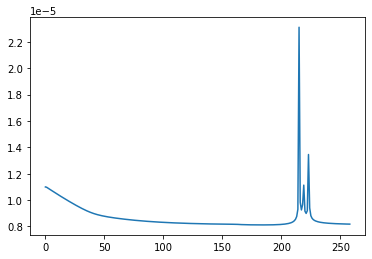

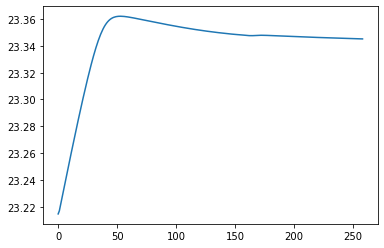

In [218]:
import matplotlib.pyplot as plt
plt.plot(range(0,len(drag)),drag)
plt.figure(2)
plt.plot(range(0,len(volu)),volu)

In [ ]:
Integrate(1,mesh)
#21.357359197038754